In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib


In [ ]:
lfw = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw.data
y = lfw.target
target_names = lfw.target_names
print(f"Dataset shape: {X.shape}, Classes: {len(target_names)}")


Dataset shape: (1288, 1850), Classes: 7


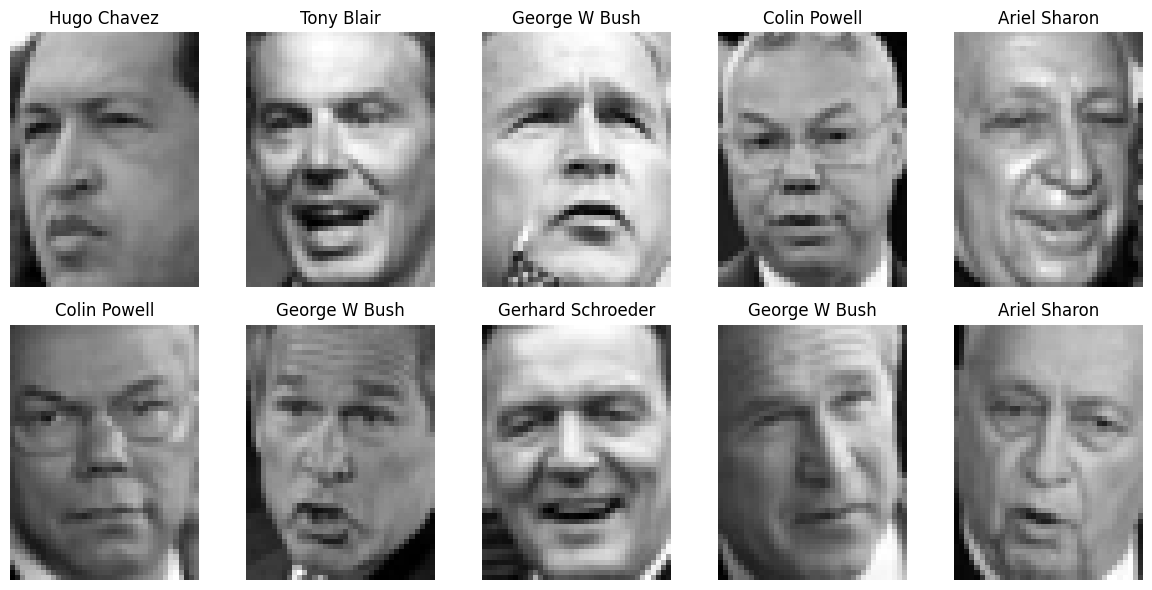

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(lfw.images[i], cmap='gray')
    ax.set_title(target_names[lfw.target[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.2, random_state=42, stratify=y)

# Standardization for NN model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Neural Network for Multi-class Classification
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_names), activation='softmax')  # Multi-class classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=30,
                    batch_size=32)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3108 - loss: 2.2314 - val_accuracy: 0.6047 - val_loss: 1.1272
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5688 - loss: 1.3494 - val_accuracy: 0.6899 - val_loss: 0.8776
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6508 - loss: 1.0933 - val_accuracy: 0.7287 - val_loss: 0.8247
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7166 - loss: 0.8252 - val_accuracy: 0.7946 - val_loss: 0.6817
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7780 - loss: 0.6315 - val_accuracy: 0.7907 - val_loss: 0.7047
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7997 - loss: 0.5930 - val_accuracy: 0.8333 - val_loss: 0.6048
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8485 - loss: 0.4807 - val_accuracy: 0.8372 - val_loss: 0.5672
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8526 - loss: 0.4549 - val_accuracy: 0.8333 - val_loss: 0.5847
Ep

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

🔎 Neural Network Classification Report:

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.75      0.75        16
     Colin Powell       0.96      0.94      0.95        47
  Donald Rumsfeld       0.75      0.75      0.75        24
    George W Bush       0.91      0.92      0.91       106
Gerhard Schroeder       0.64      0.82      0.72        22
      Hugo Chavez       0.92      0.86      0.89        14
       Tony Blair       0.92      0.76      0.83        29

         accuracy                           0.86       258
        macro avg       0.84      0.83      0.83       258
     weighted avg       0.87      0.86      0.87       258

📊 Confusion Matrix (NN):



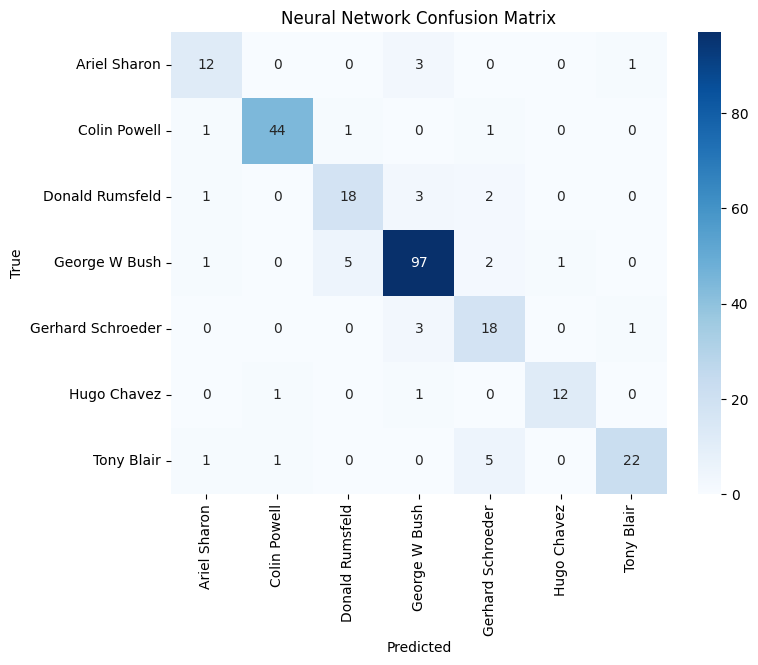

In [ ]:
y_pred_nn = model.predict(X_test_scaled)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

print("\n🔎 Neural Network Classification Report:\n")
print(classification_report(y_test, y_pred_nn_classes, target_names=target_names))

print("📊 Confusion Matrix (NN):\n")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nn_classes), annot=True, fmt='d',
            xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Neural Network Confusion Matrix")
plt.show()


In [ ]:
pca = PCA(n_components=150, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


Best Parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

🔍 SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.94      0.83        16
     Colin Powell       0.88      0.94      0.91        47
  Donald Rumsfeld       0.81      0.71      0.76        24
    George W Bush       0.88      0.93      0.90       106
Gerhard Schroeder       0.82      0.82      0.82        22
      Hugo Chavez       1.00      0.71      0.83        14
       Tony Blair       0.91      0.69      0.78        29

         accuracy                           0.86       258
        macro avg       0.86      0.82      0.83       258
     weighted avg       0.87      0.86      0.86       258



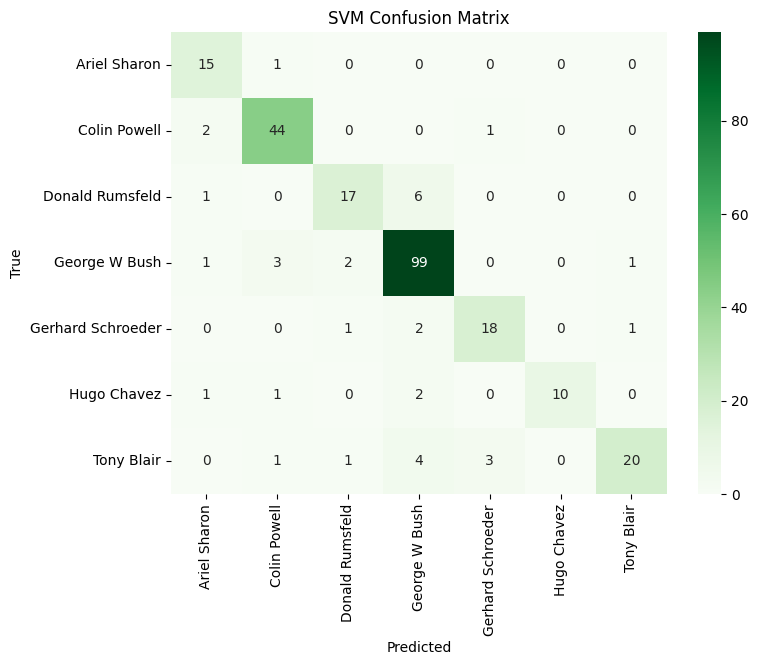

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_pca, y_train)

print("Best Parameters:", grid.best_params_)

best_svm = grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_pca)

print("\n🔍 SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=target_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d',
            xticklabels=target_names, yticklabels=target_names, cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()


In [ ]:
image_path = "/content/1920_face-new-675956.jpg"


In [ ]:
def predict_external_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (50, 37))
    img_flat = img_resized.flatten().reshape(1, -1)
    img_pca = pca.transform(img_flat)
    prediction = best_svm.predict(img_pca)
    print("Predicted Person:", target_names[prediction[0]])




In [ ]:
predict_external_image(image_path)

Predicted Person: Colin Powell


### 📌 Summary Notes to Include in Report
Metrics used: Accuracy, Precision, Recall, F1-score

Comparison: SVM vs Neural Network

Model Improvement: Hyperparameter tuning via GridSearchCV

Saved Artifacts: .h5 and .pkl models

Future Work: Add CNN, more images, real-time recognition

---

